In [1]:
import numpy as np
from scipy.stats import rankdata
import matplotlib.pyplot as plt
from scipy.integrate import quad
from matplotlib.ticker import FuncFormatter

import sys, os
sys.path.insert(0, os.path.dirname(os.getcwd()))
from metrics.calibration import *
plt.rcParams.update({
    "text.usetex": False,
    "text.latex.preamble": r"\usepackage{amsmath}",  # Optional: Include additional LaTeX packages as needed
    "font.family": "serif",  # You can specify a different font family if desired
})

In [32]:
estimate_dict = {'PE-Rank': lambda u, a, B: rank_erce_est(u, a, B, 1),\
                 'PE-Rank2': lambda u, a, B: rank_erce_est(u, a, B, 2),\
                 'DPE-Rank2': lambda u, a, B: debias_rank_erce_est(u, a, B),\
                 'ADPE-Rank2': lambda u, a: adaptive_rank_erce_est(u, a)\
                  }

def evaluation_calibrated(n, B_list, num_trials, estimate_dict, rho=0.2):

  res = {key: np.zeros((num_trials, len(B_list))) for key in estimate_dict.keys()}
  for idx_trial in range(num_trials):
    u = np.random.uniform(0, 1, size=n)
    fu = u
    a = 1-fu +np.array([np.random.uniform(-min(f*rho/(1-rho), 1-f), min(f, (1-f)*rho/(1-rho))) for f in fu]) # continuous label

    for key, estimate in estimate_dict.items():
      if key != 'ADPE-Rank2':
        for idx_B, B in enumerate(B_list):
            res[key][idx_trial][idx_B] = estimate(u, a, B)
      else:
        res[key][idx_trial][idx_B] = estimate(u, a) if idx_B == 0 else res[key][idx_trial][0]
  return res

def evaluation_non_calibrated(n, B_list, s, m, rho, num_trials, estimate_dict):

  res = {key: np.zeros((num_trials, len(B_list))) for key in estimate_dict.keys()}
  for idx_trial in range(num_trials):
    u = np.random.uniform(0, 1, size=n)
    fu = u
    perturbed_1_fu = (1+(1-2*fu)**3)/2
    # a = np.random.binomial(1, 1-perturbed_fu, n) # discrete label
    a = perturbed_1_fu+np.array([min(f, 1-f, rho) for f in fu])*np.random.uniform(-1, 1, size=n) # continuous label

    for idx_B, B in enumerate(B_list):
      for key, estimate in estimate_dict.items():
        if key != 'ADPE-Rank2':
            res[key][idx_trial][idx_B] = estimate(u, a, B)
        else:
          res[key][idx_trial][idx_B] = estimate(u, a) if idx_B == 0 else res[key][idx_trial][0]
  return res

# A synthetic perfectly calibrated toy model with $\mathbb{E}[A|F(U)]= 1-F(U)$ and $A\sim {\rm Unif}[0,1]$.

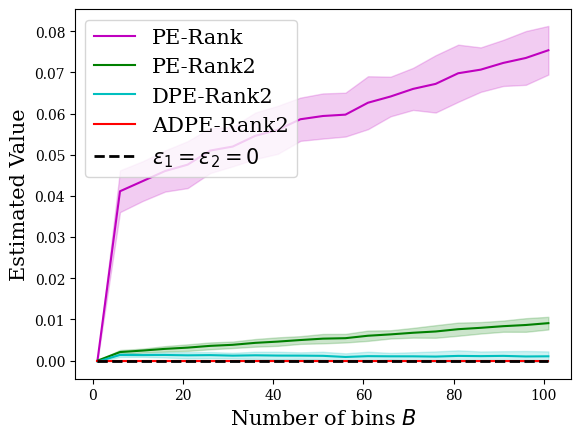

In [29]:
np.random.seed(2024) # reproducibility

n = 300
num_trials = 30

# perfect calibration, varying number of bins
B_list = range(1, 102, 5)
res = evaluation_calibrated(n, B_list, num_trials, estimate_dict)

plt.plot(B_list, res['PE-Rank'].mean(axis=0), label='PE-Rank', color='m')
plt.fill_between(B_list, res['PE-Rank'].mean(axis=0)-res['PE-Rank'].std(axis=0), res['PE-Rank'].mean(axis=0)+res['PE-Rank'].std(axis=0), color='m', alpha=0.2)

plt.plot(B_list, res['PE-Rank2'].mean(axis=0), label='PE-Rank2', color='g')
plt.fill_between(B_list, res['PE-Rank2'].mean(axis=0)-res['PE-Rank2'].std(axis=0), res['PE-Rank2'].mean(axis=0)+res['PE-Rank2'].std(axis=0), color='g', alpha=0.2)

plt.plot(B_list, res['DPE-Rank2'].mean(axis=0), label='DPE-Rank2', color='c')
plt.fill_between(B_list, res['DPE-Rank2'].mean(axis=0)-res['DPE-Rank2'].std(axis=0), res['DPE-Rank2'].mean(axis=0)+res['DPE-Rank2'].std(axis=0), color='c', alpha=0.2)

plt.plot(B_list, res['ADPE-Rank2'].mean(axis=0), label='ADPE-Rank2', color='r')
plt.fill_between(B_list, res['ADPE-Rank2'].mean(axis=0)-res['ADPE-Rank2'].std(axis=0), res['ADPE-Rank2'].mean(axis=0)+res['ADPE-Rank2'].std(axis=0), color='r', alpha=0.2)

plt.plot(B_list, np.zeros_like(B_list), '--', label='$\epsilon_1=\epsilon_2=0$', color='black', linewidth=2)

plt.xlabel('Number of bins $B$', fontsize=15)
plt.ylabel('Estimated Value', fontsize=15)
plt.legend(fontsize=15, loc='upper left')
plt.show()

(array([876., 475., 409., 375., 347., 333., 372., 440., 551., 822.]),
 array([1.58885301e-06, 1.00001172e-01, 2.00000756e-01, 3.00000339e-01,
        3.99999922e-01, 4.99999505e-01, 5.99999089e-01, 6.99998672e-01,
        7.99998255e-01, 8.99997839e-01, 9.99997422e-01]),
 <BarContainer object of 10 artists>)

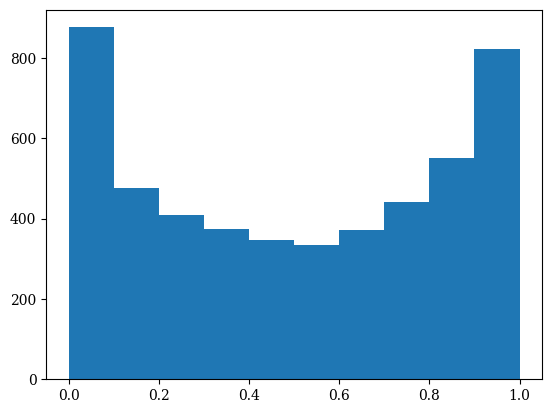

In [51]:
n = 5000
u = np.random.uniform(0, 1, size=n)
fu = u
rho = 0.5
a = 1-fu+np.array([np.random.uniform(-min(f*rho/(1-rho), 1-f), min(f, (1-f)*rho/(1-rho))) for f in fu])
plt.hist(a)

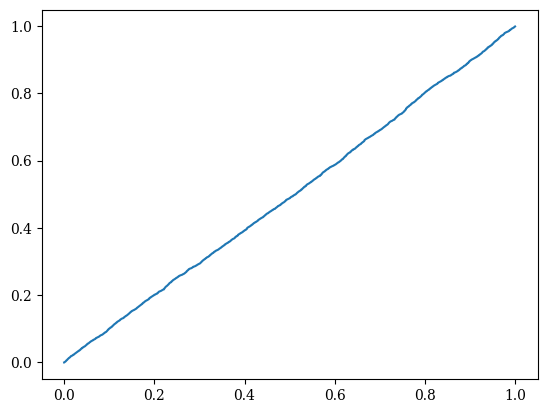

In [38]:

plt.plot(np.linspace(0,1, len(a)), np.sort(a))

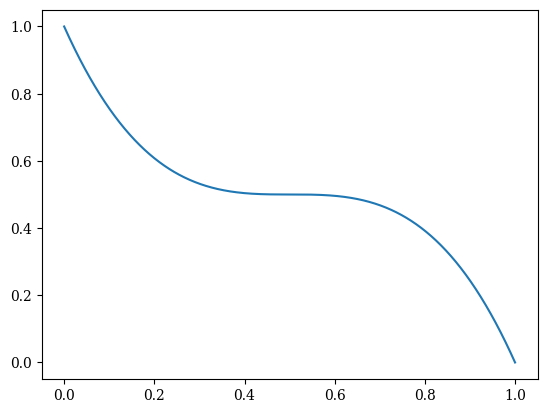

In [27]:
x = np.linspace(0, 1, 1000)
rho = 0.2
y = 1-x+np.array([np.random.uniform(-min(f*rho/(1-rho), 1-f), min(f, (1-f)*rho/(1-rho))) for f in fu])
plt.plot(x, (1+(1-2*x)**3)/2)

(array([112.,  95., 106., 117.,  92., 116., 106.,  88.,  79.,  89.]),
 array([8.71630988e-05, 9.98095131e-02, 1.99531863e-01, 2.99254213e-01,
        3.98976563e-01, 4.98698913e-01, 5.98421263e-01, 6.98143613e-01,
        7.97865963e-01, 8.97588313e-01, 9.97310663e-01]),
 <BarContainer object of 10 artists>)

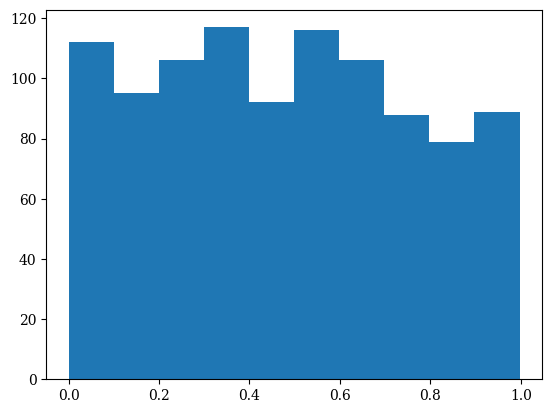

In [50]:
x = np.linspace(1+1e-5, 1-1e-5, 1000)
plt.hist(np.random.beta(2*(1-x), 2*x))

In [44]:
max(x)

1.0

In [41]:
help(np.random.beta)

Help on built-in function beta:

beta(...) method of numpy.random.mtrand.RandomState instance
    beta(a, b, size=None)
    
    Draw samples from a Beta distribution.
    
    The Beta distribution is a special case of the Dirichlet distribution,
    and is related to the Gamma distribution.  It has the probability
    distribution function
    
    .. math:: f(x; a,b) = \frac{1}{B(\alpha, \beta)} x^{\alpha - 1}
                                                     (1 - x)^{\beta - 1},
    
    where the normalization, B, is the beta function,
    
    .. math:: B(\alpha, \beta) = \int_0^1 t^{\alpha - 1}
                                 (1 - t)^{\beta - 1} dt.
    
    It is often seen in Bayesian inference and order statistics.
    
    .. note::
        New code should use the `~numpy.random.Generator.beta`
        method of a `~numpy.random.Generator` instance instead;
        please see the :ref:`random-quick-start`.
    
    
    Parameters
    ----------
    a : float or array_li

In [3]:
(2+3)./4

SyntaxError: invalid syntax (3693642827.py, line 1)